# LIBRARIES

In [ ]:
from google.colab import drive
# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Library that will used on this model
import random
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob
import cv2
import sys
import h5py

import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label                  #Used for Run-Length-Encoding RLE to create final submission
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import backend as K
import sklearn
from sklearn.model_selection import train_test_split

import keras
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam

from keras.layers import Input, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, concatenate, \
    Activation, ZeroPadding2D,Conv2DTranspose,Subtract,multiply,add,UpSampling2D,PReLU, \
    GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, multiply, Permute, Concatenate, \
    Conv2D, Add, Lambda
from keras.activations import sigmoid


from keras import regularizers
from keras.regularizers import l2
from keras.callbacks import Callback

In [ ]:
#define path of Dataset directory
path = '/content/drive/MyDrive/PCL/LEVIRCD/'
#define path of Dataset directory
#path = '/content/drive/MyDrive/ASTUDI_M/LEVIRCD/'

# METRICS

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def precision_m(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1_measure(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# ACCESSING DATASET

In [ ]:
#define visual of change images
def make_change_figure(im1, im2, im3):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,10))
    ax1.imshow(im1)
    ax1.set_title('Pre Image')
    ax1.axis('off')
    ax2.imshow(im2)
    ax2.set_title('Post Image')
    ax2.axis('off')
    d = im3 #skimage.measure.label(im3)
    ax3.imshow(np.squeeze(im3), cmap='gray')
    ax3.set_title('Ground truth')
    ax3.axis('off')

In [ ]:
#size of image
img_height, img_width = (256,256)

In [ ]:
read_h5 = h5py.File(path+'dataset_no_augmentation_256.h5', 'r')

In [ ]:
pairs_img_train = read_h5['train']['train_pairs'][:]
label_train = read_h5['train']['labeltrain'][:]

pairs_img_val = read_h5['val']['val_pairs'][:]
label_val = read_h5['val']['labelval'][:]

pairs_img_test = read_h5['test']['test_pairs'][:]
label_test = read_h5['test']['labeltest'][:]

In [ ]:
x_train_1 = pairs_img_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_img_train[:, 1]
x_val_1 = pairs_img_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_img_val[:, 1]
x_test_1 = pairs_img_test[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_test_2 = pairs_img_test[:, 1]

In [ ]:
print(x_train_1.shape, x_train_2.shape, label_train.shape)
print(x_test_1.shape, x_test_2.shape, label_test.shape)
print(x_val_1.shape, x_val_2.shape, label_val.shape)

(445, 256, 256, 3) (445, 256, 256, 3) (445, 256, 256, 1)
(128, 256, 256, 3) (128, 256, 256, 3) (128, 256, 256, 1)
(64, 256, 256, 3) (64, 256, 256, 3) (64, 256, 256, 1)


In [ ]:
print(x_train_1.dtype, x_train_2.dtype, label_train.dtype)
print(x_test_1.dtype, x_test_2.dtype, label_test.dtype)
print(x_val_1.dtype, x_val_2.dtype, label_val.dtype)

float32 float32 float32
float32 float32 float32
float32 float32 float32


In [ ]:
label_train[100].shape, x_train_2[100].shape

((256, 256, 1), (256, 256, 3))

(-0.5, 255.5, 255.5, -0.5)

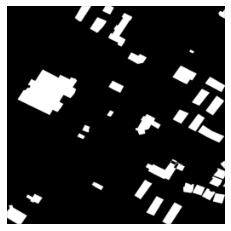

In [ ]:
plt.imshow(np.squeeze(label_train[4]), cmap='gray')
plt.axis('off')

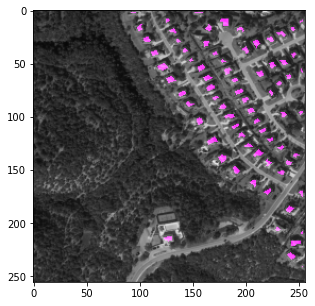

In [ ]:
from skimage import color
plt.figure(figsize=(10,5))
gt = label_train[13].reshape(256, 256)
labelled_img = color.label2rgb(gt,x_train_2[13], colors=[(255,0,255),(0,0,255)], bg_label=0, alpha=0.01, bg_color=None)
plt.imshow(labelled_img)

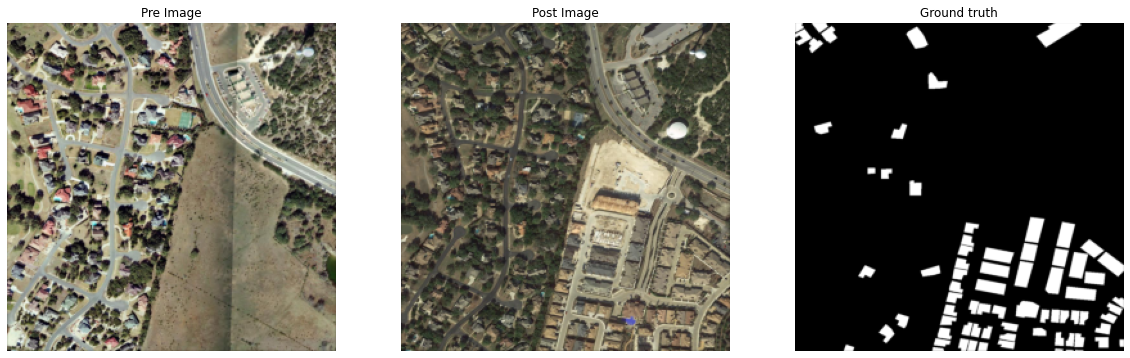

In [ ]:
make_change_figure(x_train_1[2], x_train_2[2], label_train[2])

# SPATIAL ATTENTION MODULE Definition

In [ ]:
def attach_attention_module(net, attention_module):
    if attention_module == 'se_block':  # SE_block
        net = se_block(net)
    elif attention_module == 'cbam_block':  # CBAM_block
        net = cbam_block(net)
    else:
        raise Exception("'{}' is not supported attention module!".format(attention_module))

    return net


def se_block(input_feature, ratio=8):
    """Contains the implementation of Squeeze-and-Excitation(SE) block.
    As described in https://arxiv.org/abs/1709.01507.
    """

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    se_feature = GlobalAveragePooling2D()(input_feature)
    se_feature = Reshape((1, 1, channel))(se_feature)
    assert se_feature.shape[1:] == (1, 1, channel)
    se_feature = Dense(channel // ratio,
                       activation='relu',
                       kernel_initializer='he_normal',
                       use_bias=True,
                       bias_initializer='zeros')(se_feature)
    assert se_feature.shape[1:] == (1, 1, channel // ratio)
    se_feature = Dense(channel,
                       activation='sigmoid',
                       kernel_initializer='he_normal',
                       use_bias=True,
                       bias_initializer='zeros')(se_feature)
    assert se_feature.shape[1:] == (1, 1, channel)
    if K.image_data_format() == 'channels_first':
        se_feature = Permute((3, 1, 2))(se_feature)

    se_feature = multiply([input_feature, se_feature])
    return se_feature


def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """

    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature


def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature.shape[channel_axis]

    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel // ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1, 1, channel)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel // ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1, 1, channel)

    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])


def spatial_attention(input_feature):
    kernel_size = 4

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])


def get_spatial_attention_map(input_feature):
    kernel_size = 4
    cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return cbam_feature

# MAKE MODEL

## Unet

### Model

In [ ]:
def unet():
    input_size = x_train_2[0].shape
    input1 = Input(input_size)
    input2 = Input(input_size)
    inputs = concatenate([input1, input2])

    conv0 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv0 = BatchNormalization(axis=3)(conv0)
    conv0 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0)
    conv0 = BatchNormalization(axis=3)(conv0)
    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)

    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool0)
    conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization(axis=3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization(axis=3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization(axis=3)(conv3)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization(axis=3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization(axis=3)(conv4)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization(axis=3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization(axis=3)(conv5)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization(axis=3)(conv5)
    
    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization(axis=3)(conv6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization(axis=3)(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization(axis=3)(conv7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization(axis=3)(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization(axis=3)(conv8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization(axis=3)(conv8)

    up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization(axis=3)(conv9)
    conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization(axis=3)(conv9)

    up10 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))
    merge10 = concatenate([conv0,up10], axis = 3)
    conv10 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
    conv10 = BatchNormalization(axis=3)(conv10)
    conv10 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
    conv10 = BatchNormalization(axis=3)(conv10)

    conv_out = Conv2D(1, 1, activation = 'sigmoid')(conv10)

    model = Model(inputs = [input1, input2], outputs = [conv_out])

    model.compile(optimizer = Adam(learning_rate = 1e-3), loss = [dice_loss], metrics = [dice_coef, f1_measure, recall_m, precision_m])

    return model

In [ ]:
model_unet= unet()
model_unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_24 (Concatenate)   (None, 256, 256, 6)  0           ['input_9[0][0]',                
                                                                  'input_10[0][0]']         

### Training & Testing

In [ ]:
history = model_unet.fit([x_train_1, x_train_2], label_train,
          batch_size=10,
          epochs=100,
          verbose=1,
          validation_data=([x_val_1, x_val_2], label_val),
          shuffle=True)

Epoch 1/100
45/45 [==============================] - 14s 226ms/step - loss: 0.8491 - dice_coef: 0.1504 - f1_measure: 0.1578 - recall_m: 0.7876 - precision_m: 0.0891 - val_loss: 0.9045 - val_dice_coef: 0.0982 - val_f1_measure: 0.0986 - val_recall_m: 0.1406 - val_precision_m: 0.0797
Epoch 2/100
45/45 [==============================] - 9s 205ms/step - loss: 0.7549 - dice_coef: 0.2452 - f1_measure: 0.2830 - recall_m: 0.8613 - precision_m: 0.1724 - val_loss: 0.9484 - val_dice_coef: 0.0550 - val_f1_measure: 0.0517 - val_recall_m: 0.2589 - val_precision_m: 0.0293
Epoch 3/100
45/45 [==============================] - 9s 199ms/step - loss: 0.6671 - dice_coef: 0.3296 - f1_measure: 0.3979 - recall_m: 0.8499 - precision_m: 0.2695 - val_loss: 0.9298 - val_dice_coef: 0.0752 - val_f1_measure: 0.0740 - val_recall_m: 0.6421 - val_precision_m: 0.0396
Epoch 4/100
45/45 [==============================] - 9s 199ms/step - loss: 0.5671 - dice_coef: 0.4319 - f1_measure: 0.5182 - recall_m: 0.8288 - precision_m:

In [ ]:
img_pred = model_unet.predict([x_test_1, x_test_2], batch_size=10, verbose=1)

13/13 [==============================] - 2s 68ms/step


In [ ]:
eval1 = model_unet.evaluate([x_test_1, x_test_2], label_test)

4/4 [==============================] - 1s 169ms/step - loss: 0.1958 - dice_coef: 0.8042 - f1_measure: 0.8268 - recall_m: 0.8067 - precision_m: 0.8490


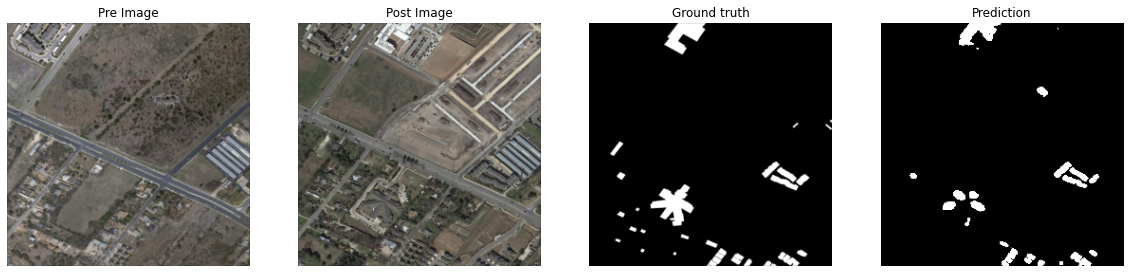

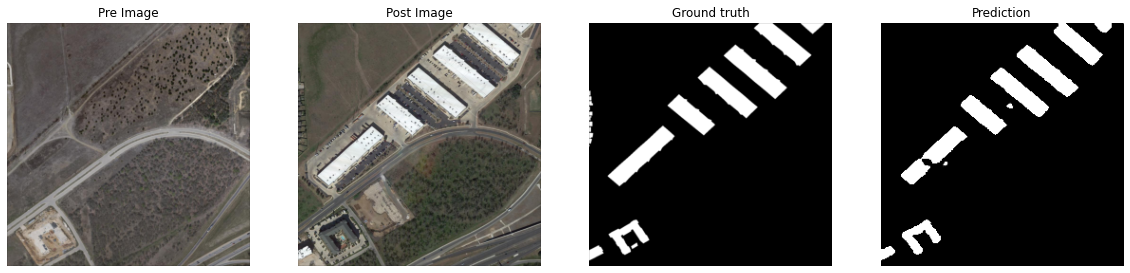

In [ ]:
for i in range(2):
  make_change_figure(x_test_1[i+3], x_test_2[i+3], label_test[i+3], img_pred[i+3])

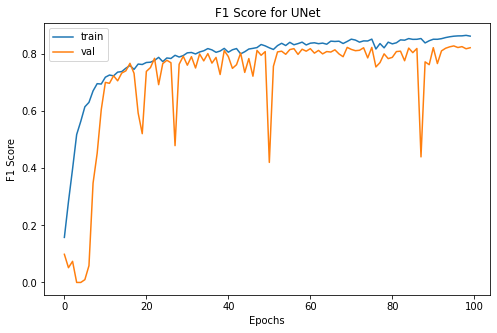

In [ ]:
plt.figure(figsize=(8,5))
plt.title('F1 Score for UNet')
plt.plot(history.history['f1_measure'])
plt.plot(history.history['val_f1_measure'])
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='best')

In [ ]:
model_unet.save(path[:-8]+"Unet_model", overwrite=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PCL/Unet_model/assets


## Siamese Unet

### Model

In [ ]:
def encoder(input):
    conv0 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
    conv0 = BatchNormalization(axis=3)(conv0)
    conv0 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0)
    conv0 = BatchNormalization(axis=3)(conv0)
    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)

    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool0)
    conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization(axis=3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization(axis=3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization(axis=3)(conv3)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization(axis=3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization(axis=3)(conv4)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization(axis=3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization(axis=3)(conv5)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization(axis=3)(conv5)
    

    return conv0, conv1, conv2, conv3, conv4, conv5

In [ ]:
input1 = Input(x_train_2[0].shape)
input2 = Input(x_train_2[0].shape)

conv0_T1, conv1_T1, conv2_T1, conv3_T1, conv4_T1, conv5_T1 = encoder(input1)
conv0_T2, conv1_T2, conv2_T2, conv3_T2, conv4_T2, conv5_T2 = encoder(input2)

conv5 = concatenate([conv5_T1, conv5_T2])

In [ ]:
up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
merge6 = concatenate([conv4_T1, conv4_T2, up6], axis = 3)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = BatchNormalization(axis=3)(conv6)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
conv6 = BatchNormalization(axis=3)(conv6)

up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3_T1, conv3_T2, up7], axis = 3)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = BatchNormalization(axis=3)(conv7)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv7 = BatchNormalization(axis=3)(conv7)

up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2_T1, conv2_T2, up8], axis = 3)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = BatchNormalization(axis=3)(conv8)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv8 = BatchNormalization(axis=3)(conv8)

up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1_T1, conv1_T2, up9], axis = 3)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = BatchNormalization(axis=3)(conv9)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization(axis=3)(conv9)

up10 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv9))
merge10 = concatenate([conv0_T1, conv0_T2, up10], axis = 3)
conv10 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
conv10 = BatchNormalization(axis=3)(conv10)
conv10 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
conv10 = BatchNormalization(axis=3)(conv10)

output = Conv2D(1, 1, activation = 'sigmoid')(conv10)

siamese_unet1 = Model(inputs = [input1, input2], outputs = [output])

siamese_unet1.compile(optimizer = Adam(learning_rate = 1e-3), loss = [dice_loss], metrics = [dice_coef, f1_measure, recall_m, precision_m])
siamese_unet1.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_12 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_152 (Conv2D)            (None, 256, 256, 8)  224         ['input_11[0][0]']               
                                                                                            

### Training&Testing

In [ ]:
history2 = siamese_unet1.fit([x_train_1, x_train_2], label_train,
          batch_size=10,
          epochs=100,
          verbose=1,
          validation_data=([x_val_1, x_val_2], label_val),
          shuffle=True)

Epoch 1/100
45/45 [==============================] - 23s 366ms/step - loss: 0.8445 - dice_coef: 0.1553 - f1_measure: 0.1745 - recall_m: 0.8150 - precision_m: 0.0990 - val_loss: 0.9183 - val_dice_coef: 0.0843 - val_f1_measure: 0.0916 - val_recall_m: 0.0517 - val_precision_m: 0.5749
Epoch 2/100
45/45 [==============================] - 13s 286ms/step - loss: 0.7560 - dice_coef: 0.2440 - f1_measure: 0.3065 - recall_m: 0.8893 - precision_m: 0.1880 - val_loss: 0.9534 - val_dice_coef: 0.0477 - val_f1_measure: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 3/100
45/45 [==============================] - 12s 275ms/step - loss: 0.6826 - dice_coef: 0.3177 - f1_measure: 0.4110 - recall_m: 0.8811 - precision_m: 0.2750 - val_loss: 0.9633 - val_dice_coef: 0.0362 - val_f1_measure: 0.0159 - val_recall_m: 0.0081 - val_precision_m: 0.4981
Epoch 4/100
45/45 [==============================] - 12s 273ms/step - loss: 0.6028 - dice_coef: 0.3999 - f1_measure: 0.5108 - recall_m: 0.8582

In [ ]:
siamese_unet1.save(path[:-8]+"siamese_Unet_model_1", overwrite=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PCL/siamese_Unet_model_1/assets


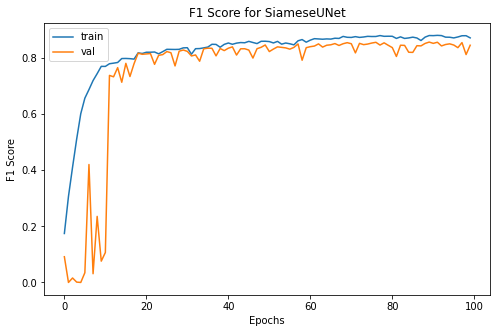

In [ ]:
plt.figure(figsize=(8,5))
plt.title('F1 Score for SiameseUNet')
plt.plot(history2.history['f1_measure'])
plt.plot(history2.history['val_f1_measure'])
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='best')

In [ ]:
img_pred2 = siamese_unet1.predict([x_test_1, x_test_2], batch_size=10, verbose=1)

13/13 [==============================] - 2s 126ms/step


In [ ]:
eval2 = siamese_unet1.evaluate([x_test_1, x_test_2], label_test)

4/4 [==============================] - 3s 223ms/step - loss: 0.1793 - dice_coef: 0.8207 - f1_measure: 0.8453 - recall_m: 0.8345 - precision_m: 0.8579


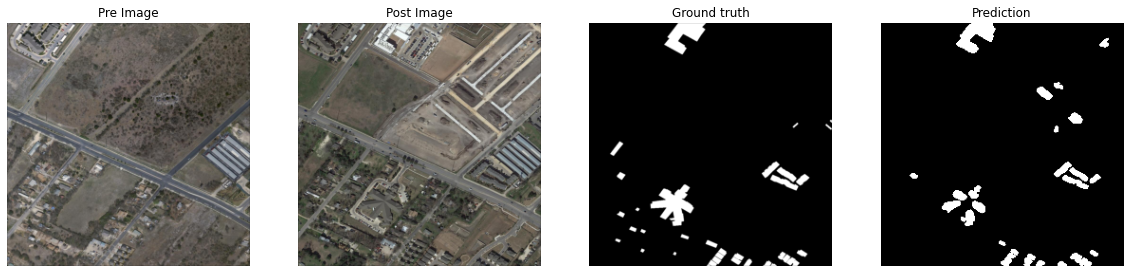

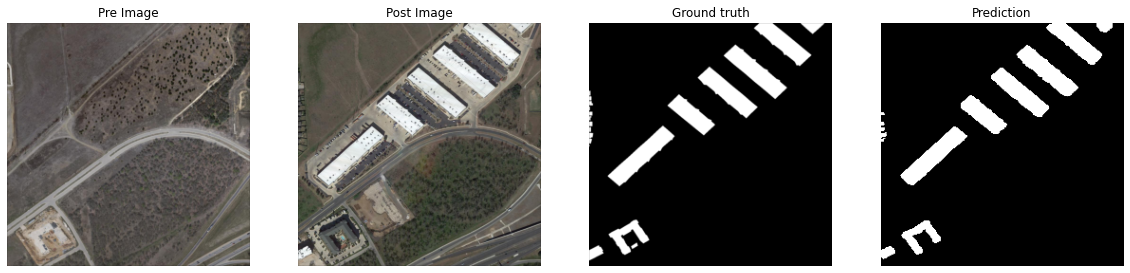

In [ ]:
for i in range(2):
  make_change_figure(x_test_1[i+3], x_test_2[i+3], label_test[i+3], img_pred2[i+3])

## Siamese Unet + SAM

### Model

In [ ]:
def encoder(input):
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
    conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization(axis=3)(conv1)

    #Attention Map 1
    attention_map_1 = get_spatial_attention_map(conv1)
    conv1 = multiply([conv1, attention_map_1])
    conv1 = BatchNormalization(axis=3)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization(axis=3)(conv2)

    #Attention Map 2
    attention_map_2 = get_spatial_attention_map(conv2)
    conv2 = multiply([conv2, attention_map_2])
    conv2 = BatchNormalization(axis=3)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization(axis=3)(conv3)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization(axis=3)(conv3)

    #Attention Map 3
    attention_map_3 = get_spatial_attention_map(conv3)
    conv3 = multiply([conv3, attention_map_3])
    conv3 = BatchNormalization(axis=3)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization(axis=3)(conv4)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization(axis=3)(conv4)

    #Attention Map 4
    attention_map_4 = get_spatial_attention_map(conv4)
    conv4 = multiply([conv4, attention_map_4])
    conv4 = BatchNormalization(axis=3)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization(axis=3)(conv5)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization(axis=3)(conv5)

    #Attention Map 5
    attention_map_5 = get_spatial_attention_map(conv5)
    conv5 = multiply([conv5, attention_map_5])
    conv5 = BatchNormalization(axis=3)(conv5)

    return conv1, conv2, conv3, conv4, conv5

In [ ]:
input1 = Input(x_train_2[0].shape)
input2 = Input(x_train_2[0].shape)

conv1_T1, conv2_T1, conv3_T1, conv4_T1, conv5_T1 = encoder(input1)
conv1_T2, conv2_T2, conv3_T2, conv4_T2, conv5_T2 = encoder(input2)

conv1 = concatenate([conv1_T1, conv1_T2])
conv2 = concatenate([conv2_T1, conv2_T2])
conv3 = concatenate([conv3_T1, conv3_T2])
conv4 = concatenate([conv4_T1, conv4_T2])
conv5 = concatenate([conv5_T1, conv5_T2])

In [ ]:
up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = channel_attention(merge6)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = BatchNormalization(axis=3)(conv6)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
conv6 = BatchNormalization(axis=3)(conv6)

#Attention Map 6
attention_map_6 = get_spatial_attention_map(conv6)
conv6 = multiply([conv6, attention_map_6])
conv6 = BatchNormalization(axis=3)(conv6)

up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = channel_attention(merge7)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = BatchNormalization(axis=3)(conv7)
conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv7 = BatchNormalization(axis=3)(conv7)

#Attention Map 7
attention_map_7 = get_spatial_attention_map(conv7)
conv7 = multiply([conv7, attention_map_7])
conv7 = BatchNormalization(axis=3)(conv7)

up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = channel_attention(merge8)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = BatchNormalization(axis=3)(conv8)
conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv8 = BatchNormalization(axis=3)(conv8)

#Attention Map 8
attention_map_8 = get_spatial_attention_map(conv8)
conv8 = multiply([conv8, attention_map_8])
conv8 = BatchNormalization(axis=3)(conv8)

up9 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = channel_attention(merge9)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = BatchNormalization(axis=3)(conv9)
conv9 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization(axis=3)(conv9)

#Attention Map 9
attention_map_9 = get_spatial_attention_map(conv9)
conv9 = multiply([conv9, attention_map_9])
conv9 = BatchNormalization(axis=3)(conv9)

output = Conv2D(1, 1, activation = 'sigmoid')(conv9)

siamese_Unet_SAM_model = Model(inputs = [input1, input2], outputs = [output])

siamese_Unet_SAM_model.compile(optimizer = Adam(learning_rate = 1e-3), loss = [dice_loss], metrics = [dice_coef, f1_measure, recall_m, precision_m])
siamese_Unet_SAM_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_14 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_192 (Conv2D)            (None, 256, 256, 16  448         ['input_13[0][0]']               
                                )                                                           

### Training & Testing

In [ ]:
history3 = siamese_Unet_SAM_model.fit([x_train_1, x_train_2], label_train,
          batch_size=10,
          epochs=100,
          verbose=1,
          validation_data=([x_val_1, x_val_2], label_val),
          shuffle=True)

Epoch 1/100
45/45 [==============================] - 46s 735ms/step - loss: 0.8092 - dice_coef: 0.1928 - f1_measure: 0.2323 - recall_m: 0.8944 - precision_m: 0.1370 - val_loss: 0.9320 - val_dice_coef: 0.0706 - val_f1_measure: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 2/100
45/45 [==============================] - 26s 586ms/step - loss: 0.7242 - dice_coef: 0.2771 - f1_measure: 0.3554 - recall_m: 0.8933 - precision_m: 0.2261 - val_loss: 0.9616 - val_dice_coef: 0.0392 - val_f1_measure: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 3/100
45/45 [==============================] - 26s 583ms/step - loss: 0.6193 - dice_coef: 0.3812 - f1_measure: 0.4753 - recall_m: 0.8650 - precision_m: 0.3354 - val_loss: 0.9940 - val_dice_coef: 0.0060 - val_f1_measure: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 4/100
45/45 [==============================] - 26s 588ms/step - loss: 0.5038 - dice_coef: 0.4977 - f1_measure: 0

In [ ]:
siamese_Unet_SAM_model.save(path[:-8]+"siamese_Unet_SAM_model", overwrite=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PCL/siamese_Unet_SAM_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
eval3 = siamese_Unet_SAM_model.evaluate([x_test_1, x_test_2], label_test)

4/4 [==============================] - 8s 437ms/step - loss: 0.1660 - dice_coef: 0.8340 - f1_measure: 0.8611 - recall_m: 0.8542 - precision_m: 0.8691


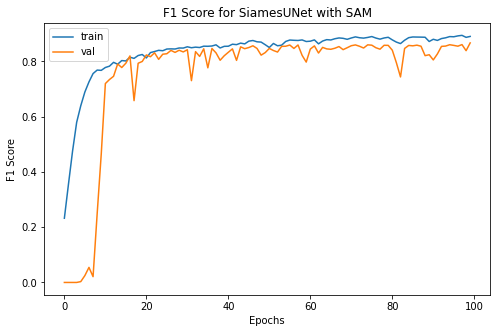

In [ ]:
plt.figure(figsize=(8,5))
plt.title('F1 Score for SiamesUNet with SAM')
plt.plot(history3.history['f1_measure'])
plt.plot(history3.history['val_f1_measure'])
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='best')

In [ ]:
img_pred5 = siamese_Unet_SAM_model.predict([x_test_1, x_test_2], batch_size=10, verbose=1)

13/13 [==============================] - 5s 358ms/step


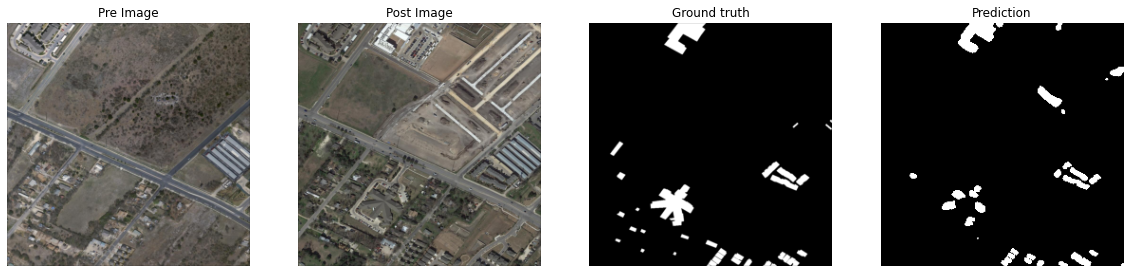

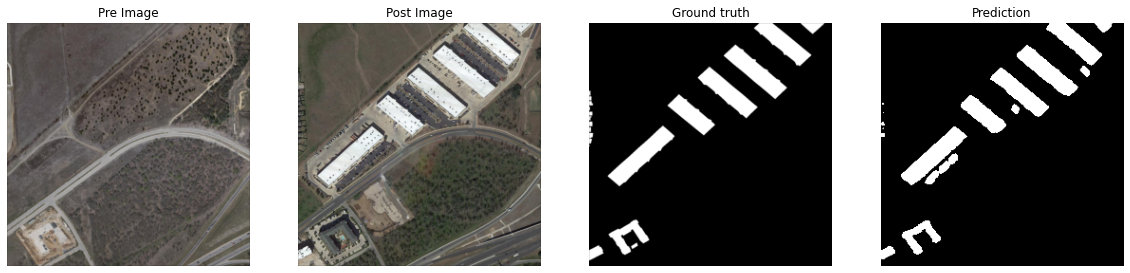

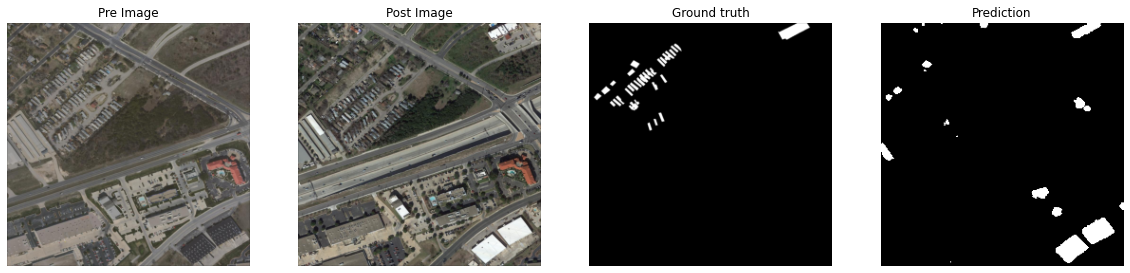

In [ ]:
for i in range(3):
  make_change_figure(x_test_1[i+3], x_test_2[i+3], label_test[i+3], img_pred5[i+3])

## UNET++

### Model

In [ ]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3, mode='None'):
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='selu', name='conv' + stage + '_1',
               kernel_initializer='he_normal', padding='same')(input_tensor)
    x0 = x
    # x = Dropout(0.2, name='dp' + stage + '_1')(x)
    x = BatchNormalization(name='bn' + stage + '_1')(x)  # much better than dropout
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation='selu', name='conv' + stage + '_2',
               kernel_initializer='he_normal', padding='same')(x)
    # x = Dropout(0.2, name='dp' + stage + '_2')(x)
    x = BatchNormalization(name='bn' + stage + '_2')(x)
    if mode == 'residual':
        # x=Add(name='resi'+stage)([x,input_tensor])# 维度不相同！
        x = Add(name='resi' + stage)([x, x0])

    return x

def Nest_Net2(input_shape, num_class=1, deep_supervision=False):
    #nb_filter = [32, 64, 128, 256, 512]
    nb_filter = [16, 32, 64, 128, 256]
    mode = 'residual'  # mode='residual' seems to improve better than DS
    # Handle Dimension Ordering for different backends
    bn_axis = 3
    input_size = input_shape
    input1 = Input(input_size)
    input2 = Input(input_size)
    inputs = concatenate([input1, input2])

    conv1_1 = standard_unit(inputs, stage='11', nb_filter=nb_filter[0])  # add 要求输入输出维度相同
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)  # (?,128,128,32)

    conv2_1 = standard_unit(pool1, stage='21', nb_filter=nb_filter[1], mode=mode)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)  # (?,64,64,64)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)  # (?,256,256,64)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0], mode=mode)  # (?,256,256,32)

    conv3_1 = standard_unit(pool2, stage='31', nb_filter=nb_filter[2], mode=mode)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1], mode=mode)

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0], mode=mode)  # (?,256,256,32)

    conv4_1 = standard_unit(pool3, stage='41', nb_filter=nb_filter[3], mode=mode)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 =standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2], mode=mode)

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1], mode=mode)

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 =standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0], mode=mode)

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4], mode=mode)

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3], mode=mode)

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2], mode=mode)

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1], mode=mode)

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 =standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0], mode=mode)

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1',
                              kernel_initializer='he_normal', padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2',
                              kernel_initializer='he_normal', padding='same')(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3',
                              kernel_initializer='he_normal', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4',
                              kernel_initializer='he_normal', padding='same')(conv1_5)
    # using combined loss
    conv_fuse = concatenate([conv1_2, conv1_3, conv1_4, conv1_5], name='merge_fuse', axis=bn_axis)
    nestnet_output_5 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_5',
                              kernel_initializer='he_normal', padding='same')(conv_fuse)


    if deep_supervision:
        model = Model(inputs = [input1, input2], outputs=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4, nestnet_output_5])
        model.compile(optimizer=Adam(learning_rate=1e-3),
                      #loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy','binary_crossentropy'],
                      loss=[dice_loss, dice_loss, dice_loss,
                            dice_loss, dice_loss],
                      #loss_weights=[0.5, 0.5, 0.75, 0.5, 1.0],
                      metrics = [dice_coef]
                      )
    else:
        model = Model(inputs = [input1, input2], outputs=[nestnet_output_4])
        model.compile(optimizer = Adam(learning_rate = 1e-2), loss = [dice_loss], metrics = [dice_coef, f1_measure, recall_m, precision_m])

    model.summary()
    return model

In [ ]:
input_shape = x_train_2[0].shape
model_Unetnet=Nest_Net2(input_shape,deep_supervision=False)
output_layer=model_Unetnet.get_layer('output_4')
print("the output shape is:")
print(output_layer.output_shape)

### Training Testing

In [ ]:
history6 = model_Unetnet.fit([x_train_1, x_train_2], label_train,
          batch_size=10,
          epochs=50,
          verbose=1,
          validation_data=([x_val_1, x_val_2], label_val),
          shuffle=True)

Epoch 1/50
45/45 [==============================] - 48s 916ms/step - loss: 0.6086 - dice_coef: 0.3908 - val_loss: 0.7214 - val_dice_coef: 0.2738
Epoch 2/50
45/45 [==============================] - 41s 903ms/step - loss: 0.4333 - dice_coef: 0.5670 - val_loss: 0.9974 - val_dice_coef: 0.0034
Epoch 3/50
45/45 [==============================] - 40s 892ms/step - loss: 0.3611 - dice_coef: 0.6397 - val_loss: 0.8199 - val_dice_coef: 0.1816
Epoch 4/50
45/45 [==============================] - 41s 903ms/step - loss: 0.3568 - dice_coef: 0.6439 - val_loss: 0.4106 - val_dice_coef: 0.5872
Epoch 5/50
45/45 [==============================] - 40s 893ms/step - loss: 0.3146 - dice_coef: 0.6863 - val_loss: 0.5376 - val_dice_coef: 0.4659
Epoch 6/50
45/45 [==============================] - 41s 904ms/step - loss: 0.3011 - dice_coef: 0.6978 - val_loss: 0.4234 - val_dice_coef: 0.5770
Epoch 7/50
45/45 [==============================] - 41s 902ms/step - loss: 0.2578 - dice_coef: 0.7427 - val_loss: 0.3354 - val_dic

In [ ]:
model_Unetnet.save(path[:-8]+"Unet++_Model", overwrite=True)

In [ ]:
model_Unetnet.evaluate([x_test_1, x_test_2], label_test)

4/4 [==============================] - 13s 840ms/step - loss: 0.4752 - dice_coef: 0.7321


[0.4752454161643982, 0.7321174144744873]

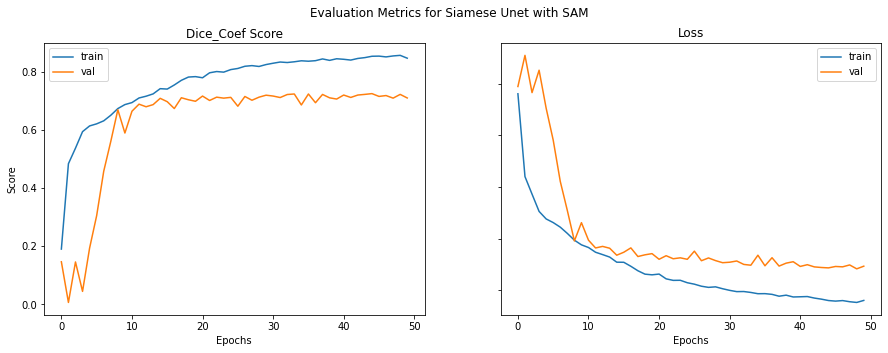

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Evaluation Metrics for Siamese Unet with SAM')
ax1.plot(history6.history['dice_coef'])
ax1.plot(history6.history['val_dice_coef'])
ax1.set_title('Dice_Coef Score')
ax1.legend(['train', 'val'], loc='best')

ax2.plot(history6.history['loss'])
ax2.plot(history6.history['val_loss'])
ax2.set_title('Loss')
ax2.legend(['train', 'val'], loc='best')

for ax in fig.get_axes():
    ax.set(xlabel='Epochs', ylabel='Score')

for ax in fig.get_axes():
    ax.label_outer()

# Print Model

## Unet

In [ ]:
model1 = tf.keras.models.load_model(path[:-8]+"Unet_model/", custom_objects={'dice_coef':dice_coef, 'f1_measure':f1_measure, 
                                                                             'recall_m':recall_m, 'precision_m':precision_m,
                                                                             'dice_loss':dice_loss})

In [ ]:
import time

start = time.process_time()
eval1 = model1.evaluate([x_test_1, x_test_2], label_test)
end = time.process_time()
print ("%.3gs" % (end-start))


In [ ]:
pred1 = model1.predict([x_test_1, x_test_2], batch_size=10, verbose=1)

In [ ]:
def make_change_figure(im1, im2, im3):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,10))
    ax1.imshow(im1)
    ax1.set_title('Pre Image')
    ax1.axis('off')
    ax2.imshow(im2)
    ax2.set_title('Post Image')
    ax2.axis('off')
    d = im3 #skimage.measure.label(im3)
    ax3.imshow(np.squeeze(im3), cmap='gray')
    ax3.set_title('prediction')
    ax3.axis('off')

## Siamese Unet

In [ ]:
model2 = tf.keras.models.load_model(path[:-8]+"siamese_Unet_model_1/", custom_objects={'dice_coef':dice_coef, 'f1_measure':f1_measure, 
                                                                             'recall_m':recall_m, 'precision_m':precision_m,
                                                                             'dice_loss':dice_loss})

In [ ]:
start = time.process_time()
eval2 = model2.evaluate([x_test_1, x_test_2], label_test)
end = time.process_time()
print ("%.3gs" % (end-start))


4/4 [==============================] - 4s 236ms/step - loss: 0.1793 - dice_coef: 0.8207 - f1_measure: 0.8453 - recall_m: 0.8345 - precision_m: 0.8579
3.77s


In [ ]:
pred2 = model2.predict([x_test_1, x_test_2], batch_size=10, verbose=1)

13/13 [==============================] - 4s 112ms/step


## Siamese Unet SAM

In [ ]:
model3 = tf.keras.models.load_model(path[:-8]+"siamese_Unet_SAM_model/", custom_objects={'dice_coef':dice_coef, 'f1_measure':f1_measure, 
                                                                             'recall_m':recall_m, 'precision_m':precision_m,
                                                                             'dice_loss':dice_loss})

In [ ]:
start = time.process_time()
eval3 = model3.evaluate([x_test_1, x_test_2], label_test)
end = time.process_time()
print ("%.3gs" % (end-start))

pred3 = model3.predict([x_test_1, x_test_2], batch_size=10, verbose=1)

4/4 [==============================] - 8s 442ms/step - loss: 0.1660 - dice_coef: 0.8340 - f1_measure: 0.8611 - recall_m: 0.8542 - precision_m: 0.8691
8.21s
13/13 [==============================] - 7s 299ms/step


In [ ]:
ev1 = [x*100 for x in eval1]
ev2 = [y*100 for y in eval2]
ev3 = [z*100 for z in eval3]

## Display Comparison

In [ ]:
pd.DataFrame({'UNet':ev1, 'SiameseUNet':ev2, 'SiameseUNet+SAM':ev3}, index=['Loss', 'Dice Coef', 'F1 Score', 'Recall', 'Precision']).T

Loss  Dice Coef   F1 Score     Recall  Precision
UNet             19.578303  80.421698  82.684684  80.671662  84.901023
SiameseUNet      17.931363  82.068634  84.528792  83.450699  85.793459
SiameseUNet+SAM  16.599503  83.400494  86.114287  85.421741  86.914444

In [ ]:
def compar_images(img1, img2, img3, img4, img5, img6):
    fig, ax = plt.subplots(5, 6, figsize = (20,17))
    name_plot = ['Pre Image', 'Post Image', 'Ground Truth', 'UNet', 'SiameseUNet', 'SiameseUNet+SAM']
    for i in range(5):
      ax[i, 0].imshow(img1[i])
      ax[i, 0].axis('off')
      ax[i, 1].imshow(img2[i])
      ax[i, 1].axis('off')
      ax[i, 2].imshow(np.squeeze(img3[i]), cmap='gray')
      ax[i, 2].axis('off')
      ax[i, 3].imshow(np.squeeze(img4[i]), cmap='gray')
      ax[i, 3].axis('off')
      ax[i, 4].imshow(np.squeeze(img5[i]), cmap='gray')
      ax[i, 4].axis('off')
      ax[i, 5].imshow(np.squeeze(img6[i]), cmap='gray')
      ax[i, 5].axis('off')

      ax[0, i].set_title(name_plot[i])
      ax[0, 5].set_title(name_plot[5])
      #ax[i, 0].set_title(str(i+1))      
      
    plt.show()

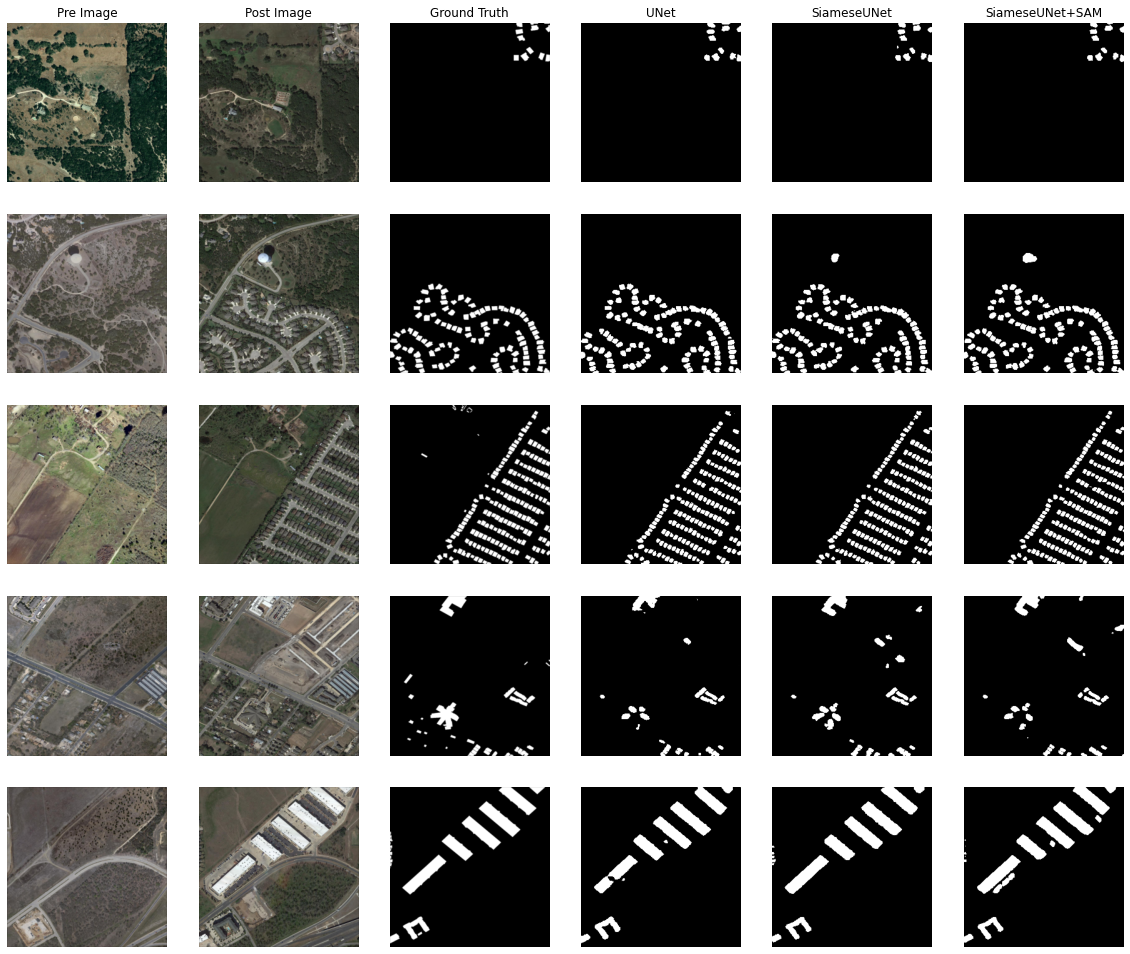

In [ ]:
compar_images(x_test_1[:5], x_test_2[:5], label_test[:5], pred1[:5], pred2[:5], pred3[:5])

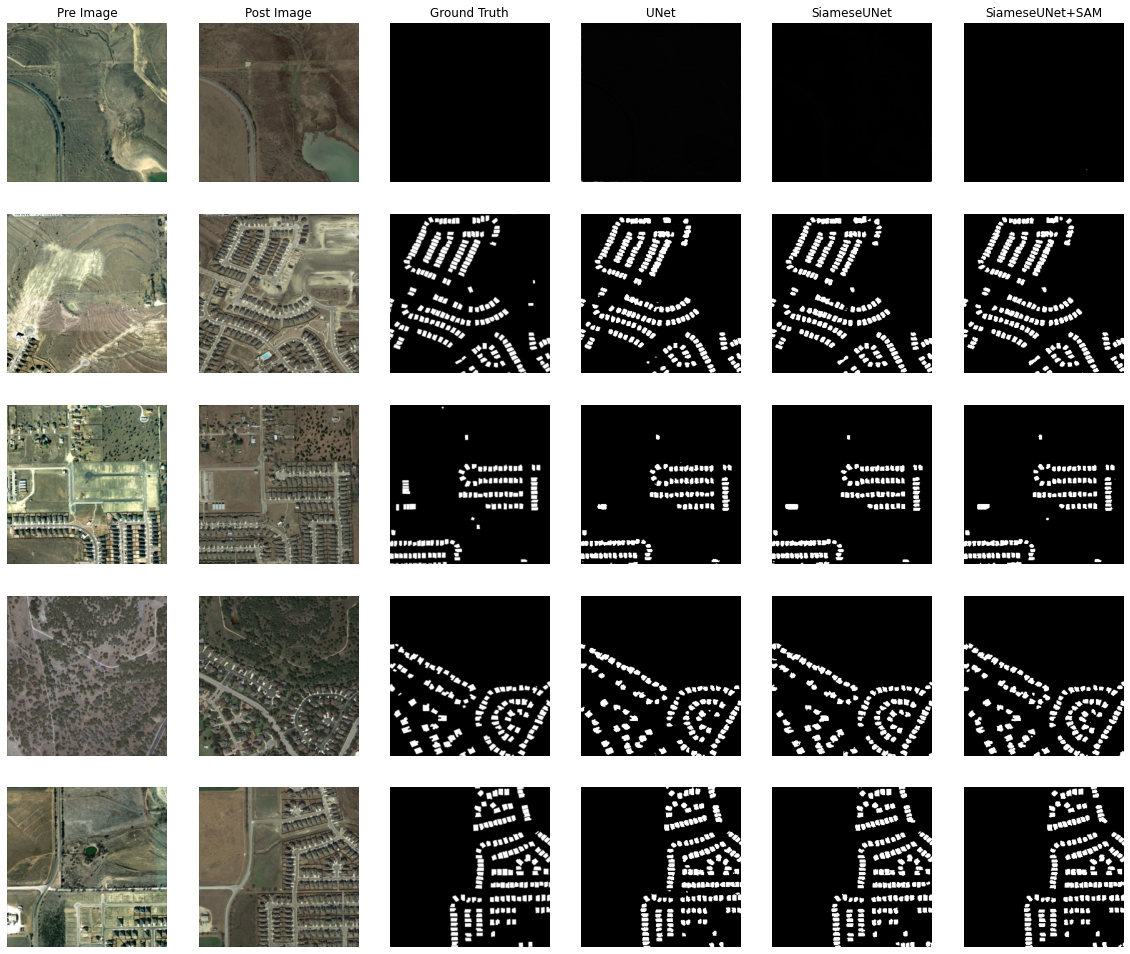

In [ ]:
compar_images(x_test_1[20:25], x_test_2[20:25], label_test[20:25], pred1[20:25], pred2[20:25], pred3[20:25])